In [58]:
import numpy as np
import mdtraj as md
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

<html> 
    <head> 
        <font size=6> <strong> Generate a trajectory of alanine dipeptide  </strong></font>
    </head>
</html>
    
       

In [41]:
from openmm import *
from simtk.openmm import *
from simtk.openmm.app import *
from simtk.unit import *

psf = CharmmPsfFile('A.psf')
pdb = PDBFile('A.pdb')
params = CharmmParameterSet('top_all27_prot_lipid.rtf', 'par_all27_prot_lipid.prm') #load all the definition files into a CharmmParameterSet object to provide a set of files containing the force field definition to use

# System Configuration
nonbondedMethod = CutoffNonPeriodic
nonbondedCutoff = 1*nanometers #1 nm cutoff for the direct space interactions #1.4
constraints = HBonds #constrain the length of all bonds that involve a hydrogen atom
constraintTolerance = 0.00001

system = psf.createSystem(params,nonbondedMethod=nonbondedMethod,nonbondedCutoff=nonbondedCutoff,constraints=constraints)

# Integration Options
dt = 0.001*picoseconds #0.002
temperature = 800.00*kelvin
friction = 1/picosecond #2
integrator = LangevinIntegrator(temperature, friction, dt) #the integrator to use for advancing the equations of motion
integrator.setConstraintTolerance(constraintTolerance)

# do minimization, perform equilibration, then save the state of the simulation
equilibrationSteps = 1000000
platform = Platform.getPlatformByName('CPU')
platformProperties = {'CpuThreads':'1'}

simulation = Simulation(psf.topology, system, integrator, platform, platformProperties)
simulation.context.setPositions(pdb.positions) #specifies the initial atom positions for the simulation, in this case, the positions that were loaded from the PDB file

# Minimize and Equilibrate
print('Performing energy minimization...')
simulation.minimizeEnergy()

#----I ADD---
simulation.reporters.append(PDBReporter('output_traj2.pdb', 100))
#generate output during the simulation, and adds it to the Simulation object’s list of reporters
# We specify that the output file should be called output_traj.pdb, and that a structure should be written every 1000 time steps
#----END MODIFY

print('Equilibrating...')
simulation.context.setVelocitiesToTemperature(temperature)
simulation.step(equilibrationSteps) #we run the simulation, integrating the equations of motion for 10,000 time steps

simulation.currentStep = 0
simulation.context.setTime(0.0)

state = simulation.context.getState(getPositions=True, getVelocities=True,
		                 getForces=True, getEnergy=True, getParameters=True)

#PDBFile.writeFile(simulation.topology,state.getPositions(),open('after_equil_gas.pdb','w'))

#serialize the state to xml for load in parRep later
#print('Serializing state : it contains coordinates, velocities, etc. for parRep...')
#f = open('State.xml','w')
#f.write(XmlSerializer.serialize(state))
#f.close()

#serialize the system to xml for load in parRep later
#print('Serializing system : it contains all definition of forces for parRep...')
#f = open('System.xml','w')
#f.write(XmlSerializer.serialize(system))
#f.close()

#serialize the integrator to xml for load in parRep later
#print('Serializing integrator for parRep...')
#f = open('Integrator.xml','w')
#f.write(XmlSerializer.serialize(integrator))
#f.close()

Performing energy minimization...
Equilibrating...


In [12]:
# Print some line of the PDB to understand the structure
with open('output_traj2.pdb') as pdbfile:
    k=0
    for line in pdbfile:
        k +=1
        print(line)
        if k==25:
            break

REMARK   1 CREATED WITH OPENMM 7.6, 2022-02-18

MODEL        1

ATOM      1  CAY ALA A   1       3.405   0.252  13.785  1.00  0.00           C  

ATOM      2  HY1 ALA A   1       2.727   1.027  13.367  1.00  0.00           H  

ATOM      3  HY2 ALA A   1       3.744   0.598  14.785  1.00  0.00           H  

ATOM      4  HY3 ALA A   1       2.895  -0.735  13.804  1.00  0.00           H  

ATOM      5  CY  ALA A   1       4.593   0.146  13.012  1.00  0.00           C  

ATOM      6  OY  ALA A   1       4.545  -0.569  12.044  1.00  0.00           O  

ATOM      7  N   ALA A   1       5.691   0.813  13.383  1.00  0.00           N  

ATOM      8  H   ALA A   1       5.681   1.287  14.260  1.00  0.00           H  

ATOM      9  CA  ALA A   1       7.018   0.767  12.722  1.00  0.00           C  

ATOM     10  HA  ALA A   1       7.571   1.524  13.258  1.00  0.00           H  

ATOM     11  CB  ALA A   1       7.663  -0.603  13.035  1.00  0.00           C  

ATOM     12  HB1 ALA A   1       7

Remove rotation (and translation) with mdtraj

In [49]:
traj = md.load('output_traj2.pdb')

#remove rotation and translation (don't modify the conformation)
#traj.superpose(traj, atom_indices=[5, 7, 11, 17]) #Trajectory.superpose(reference, frame=0, atom_indices=None, ref_atom_indices=None, parallel=True)
traj.superpose(traj, atom_indices=[1, 2, 5, 7, 11, 17, 19, 20])
#save it
traj.save_pdb("clear_traj2.pdb")

# Save trajectory
The input features are chosen as the Cartesian coordinates of only the backbone atoms of alanine dipeptide, instead of the complete peptide. So 

In [50]:
with open('3dTraj_8Atoms.txt', 'w') as f:
    with open('clear_traj2.pdb') as pdbfile:
        for line in pdbfile:
            if line[:4] =='ATOM': 
                if line[9:11] == ' 1' or line[9:11] == ' 5' or line[9:11] == ' 7' or line[9:11] == ' 8' or line[9:11] == '11' or line[9:11] == '15' or line[9:11] == '17' or line[9:11] == '19':
                    f.write(line[33:56])
                    f.write('\n')

# Compute dihedral angle

with mdtraj

In [43]:
traj = md.load('clear_traj2.pdb')
#traj = md.load('output_traj2.pdb')
#atoms, bonds = traj.topology.to_dataframe()
#psi_indices, phi_indices = [5, 7, 9, 15], [7, 9, 15, 17]
phi_indices, psi_indices = [5, 7, 9, 15], [7, 9, 15, 17]
#psi_indices, phi_indices = [5, 7, 9, 11], [9, 11, 15, 17]
#psi_indices, phi_indices = [4, 6, 8, 10], [8, 10, 14, 16]

angles = md.compute_dihedrals(traj, [phi_indices, psi_indices])

In [44]:
angles.shape[0]

10000

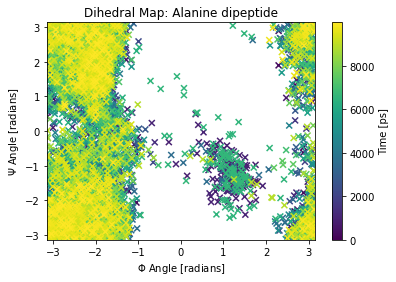

In [45]:
# Plot Ramachandran plot
from pylab import *

from math import pi

def rama_plot():
    fig = figure()
    title('Dihedral Map: Alanine dipeptide')
    scatter(angles[:, 0], angles[:, 1], marker='x', c=traj.time)
    cbar = colorbar()
    cbar.set_label('Time [ps]')
    xlabel(r'$\Phi$ Angle [radians]')
    xlim(-pi, pi)
    ylabel(r'$\Psi$ Angle [radians]')
    ylim(-pi, pi)

    plt.show()
    return fig
f = rama_plot() 

In [46]:
import plotly.express as px
import pandas as pd
#df = pd.DataFrame(data = angles[:, 1], index=angles[:,0], columns= range(0, 2500))
df=pd.DataFrame(angles, columns=['$\Phi$', '$\Psi$'] )
df['Time'] = range(angles.shape[0])
#print(df)
fig = px.scatter(df, x='$\Phi$', y='$\Psi$', color = 'Time', title='Rama plot')
#px.ylim(-3.2, 3.2)
fig.show()

In [21]:
px.scatter?

In [51]:
fig = px.scatter(df, x='$\Phi$', y='$\Psi$', color = 'Time', title='Rama plot', animation_frame="Time")
#fig["layout"].pop("updatemenus") 
fig.show()

KeyboardInterrupt: 

In [6]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step in np.arange(0, 5, 0.1):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=6),
            name="𝜈 = " + str(step),
            x=np.arange(0, 10, 0.01),
            y=np.sin(step * np.arange(0, 10, 0.01))))

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + str(i)}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

#fig.savefig()

In [8]:
import os
basedir = os.path.abspath(os.path.dirname('codeINES.py'))
print(basedir)

C:\Users\INES\Documents\2MOPSI


# Autoencoder: get the CVs

First, we need to define the class used for the neural network for importing our autoencoder model

In [52]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, bottleneck_dim):
        """Initialise auto encoder with hyperbolic tangent activation function

        :param input_dim: int, Number of dimension of the input vectors
        :param hidden_dims: list, List of hidden layers
        :param bottleneck_dim: int, Number of dimension of the bottleneck
        """
        super(DeepAutoEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dims[0]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[-1], bottleneck_dim),
            torch.nn.Tanh()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(bottleneck_dim, hidden_dims[-1]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[0], input_dim),
        )

    def forward(self, inp):
        # Input Linear function
        encoded = self.encoder(inp)
        decoded = self.decoder(encoded)
        return decoded

In [53]:
ae = torch.load('AE_model')
print(ae)
def cv_ae(model, x):
    """Collective variable defined through an auto encoder model

    :param model: Neural network model build with pytorch,
    :param x: np.array, position, ndim = 2, shape = (1,1)

    :return: xi: np.array
    """
    model.eval()
    x = torch.tensor(x.astype('float32'))
    return model.encoder(x).detach().numpy()

DeepAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=24, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=2, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=24, bias=True)
  )
)


In [54]:
T = 10000 #time discrimination
data = np.loadtxt('3dTraj_8Atoms.txt')
trajN = np.reshape(data, (T, 24)) 

In [55]:
cvs_ae = np.zeros([T, 2])
for i in range(T):
    cvs_ae[i,:] = cv_ae(ae, trajN[i,:])

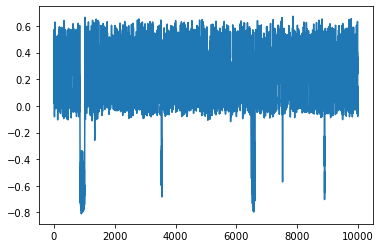

In [56]:
plt.plot(cvs_ae[:, 1])

In [ ]:
plt.plot(cvs_ae[:, 0])

# Linear regression

<b>angles</b> stores $\phi$ ans $\psi$ angle for each time
<b>cvs_ae</b> stores the Cvs for each time

In [57]:
PHI = angles[:, 0]
PSI = angles[:, 1]

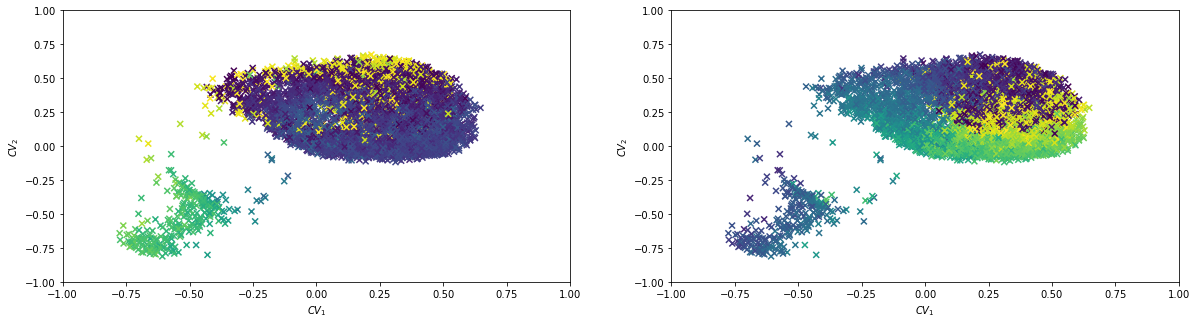

In [59]:
#title('Dihedral Map: Alanine dipeptide')
figure, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(cvs_ae[:, 0], cvs_ae[:, 1], marker='x', c = PHI)
ax[0].set_xlabel('$CV_1$')
ax[0].set_ylabel('$CV_2$')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)

ax[1].scatter(cvs_ae[:, 0], cvs_ae[:, 1], marker='x', c = PSI)
ax[1].set_xlabel('$CV_1$')
ax[1].set_ylabel('$CV_2$')
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)

plt.show()

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#import matplotlib.pyplot as plt

Linear regression FOR $\phi$

In [61]:
PHI_regression_model= LinearRegression()
PHI_regression_model.fit(cvs_ae, PHI)

LinearRegression()

In [62]:
# Prédiction
phi_predicted = PHI_regression_model.predict(cvs_ae)

# Évaluation du modèle
rmse = mean_squared_error(PHI, phi_predicted)
r2 = r2_score(PHI, phi_predicted)

# Affichage des valeurs
print("Pente : " ,PHI_regression_model.coef_)
print("Ordonnée à l'origine : ", PHI_regression_model.intercept_)
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print('Score R^2 : ', r2) #coefficient de détermination 

Pente :  [-1.84470671  0.54753379]
Ordonnée à l'origine :  -1.2919819871609328
Racine carrée de l'erreur quadratique moyenne :  2.774820012873874
Score R^2 :  0.05284136830494213


Linear Regression for $\psi$

In [63]:
PSI_regression_model= LinearRegression()
PSI_regression_model.fit(cvs_ae, PSI)

LinearRegression()

In [64]:
# Prédiction
psi_predicted = PSI_regression_model.predict(cvs_ae)

# Évaluation du modèle
rmse = mean_squared_error(PSI, psi_predicted)
r2 = r2_score(PSI, psi_predicted)

# Affichage des valeurs
print("Pente : " ,PSI_regression_model.coef_)
print("Ordonnée à l'origine : ", PSI_regression_model.intercept_)
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print('Score R^2 : ', r2) #coefficient de détermination 

Pente :  [ 3.14563784 -4.97393391]
Ordonnée à l'origine :  0.34412867795432006
Racine carrée de l'erreur quadratique moyenne :  3.4951297991815955
Score R^2 :  0.27899808203600407
